# Exploratory Analysis — Operations Intelligence Challenge

**Author:** Guilherme Breda Rezende  
**Purpose:** Concise exploratory notebook to validate the dataset, run basic ETL checks, compute core KPIs, and produce preliminary visualizations prior to dashboarding in Looker Studio.

**Inputs**
- `Operations_analyst_data.csv` — transaction dataset provided in the challenge.

**Notes**
- Visuals are created with **matplotlib** (no seaborn).
- The notebook is intentionally concise and focused on the minimum exploration needed to inform the dashboard design.

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display options for readability
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")

### Load Data & Normalize Columns

In [3]:
# Path to CSV (expected in the repo root). Adjust if you place it under /data.
CSV_PATH = "Operations_analyst_data.csv"

# Load
df = pd.read_csv(CSV_PATH)

# Normalize column names to snake_case for convenience
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Preview
print("Shape:", df.shape)
df.head()

Shape: (37787, 10)


,day,entity,product,price_tier,anticipation_method,payment_method,installments,amount_transacted,quantity_transactions,quantity_of_merchants
0,2025-01-01,PJ,pix,intermediary,Pix,uninformed,1,"546,030.68",13361,675
1,2025-01-01,PJ,pos,intermediary,D1Anticipation,credit,1,"574,568.13",9104,694
2,2025-01-01,PJ,tap,normal,D0/Nitro,credit,1,"342,178.87",2655,1607
3,2025-01-01,PJ,tap,domination,D1Anticipation,debit,1,"1,183.21",63,9
4,2025-01-01,PJ,tap,aggressive,D0/Nitro,credit,1,"10,158.11",30,20


### Data Quality Checks 

In [4]:
# Types & non-null counts
print("\n.info():")
print(df.info())

# Nulls by column
print("\nNulls per column:")
print(df.isna().sum())

# Duplicates
dup_count = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_count}")

# Basic numeric sanity (min/max) for key metrics
numeric_cols = ["amount_transacted", "quantity_transactions", "quantitu_of_merchants"]
present_cols = [c for c in numeric_cols if c in df.columns]
print("\nDescribe (key numeric columns):")
print(df[present_cols].describe())


.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37787 entries, 0 to 37786
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   day                    37787 non-null  object 
 1   entity                 37787 non-null  object 
 2   product                37787 non-null  object 
 3   price_tier             37787 non-null  object 
 4   anticipation_method    37787 non-null  object 
 5   payment_method         37787 non-null  object 
 6   installments           37787 non-null  int64  
 7   amount_transacted      37787 non-null  float64
 8   quantity_transactions  37787 non-null  int64  
 9   quantity_of_merchants  37787 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 2.9+ MB
None

Nulls per column:
day                      0
entity                   0
product                  0
price_tier               0
anticipation_method      0
payment_method           0
installme

### Minimal Transformations

In [5]:
# Parse date column
if "day" in df.columns:
    df["day"] = pd.to_datetime(df["day"], errors="coerce")
    # Weekday for later plots/aggregation
    df["weekday"] = df["day"].dt.day_name()

# Ensure numeric columns are numeric (coerce any unexpected strings)
for col in ["amount_transacted", "quantity_transactions", "quantity_of_merchants"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Derived metric: Average Ticket per row (safe division)
df["avg_ticket_row"] = df["amount_transacted"] / df["quantity_transactions"].replace(0, np.nan)

# Quick look at transformed columns
df[["day","weekday","amount_transacted","quantity_transactions","quantity_of_merchants","avg_ticket_row"]].head()

,day,weekday,amount_transacted,quantity_transactions,quantity_of_merchants,avg_ticket_row
0,2025-01-01,Wednesday,"546,030.68",13361,675,40.87
1,2025-01-01,Wednesday,"574,568.13",9104,694,63.11
2,2025-01-01,Wednesday,"342,178.87",2655,1607,128.88
3,2025-01-01,Wednesday,"1,183.21",63,9,18.78
4,2025-01-01,Wednesday,"10,158.11",30,20,338.60


### Core KPIs

In [6]:
TPV = df["amount_transacted"].sum()
total_tx = df["quantity_transactions"].sum()
avg_ticket = TPV / total_tx if total_tx else np.nan
total_merchants = df["quantitu_of_merchants"].sum() if "quantitu_of_merchants" in df.columns else np.nan

print(f"Total Payment Volume (TPV): R$ {TPV:,.2f}")
print(f"Total Transactions: {total_tx:,.0f}")
print(f"Average Ticket: R$ {avg_ticket:,.2f}")
print(f"Total Merchants: {total_merchants:,.0f}")

Total Payment Volume (TPV): R$ 19,442,634,813.40
Total Transactions: 146,496,103
Average Ticket: R$ 132.72
Total Merchants: nan


### Segment Summaries

In [7]:
def topn(df_in, by, n=10, ascending=False):
    return df_in.sort_values(by=by, ascending=ascending).head(n)

# TPV by dimensions
tpv_by_entity = df.groupby("entity", dropna=False)["amount_transacted"].sum().reset_index(name="tpv")
tpv_by_product = df.groupby("product", dropna=False)["amount_transacted"].sum().reset_index(name="tpv")
tpv_by_payment = df.groupby("payment_method", dropna=False)["amount_transacted"].sum().reset_index(name="tpv")

# Average ticket by dimensions using global definition SUM(amount)/SUM(qty)
def avg_ticket_by(group_cols):
    agg = df.groupby(group_cols, dropna=False).agg(
        tpv=("amount_transacted","sum"),
        tx=("quantity_transactions","sum")
    ).reset_index()
    agg["avg_ticket"] = agg["tpv"] / agg["tx"].replace(0, np.nan)
    return agg

avg_by_product = avg_ticket_by(["product"])
avg_by_entity  = avg_ticket_by(["entity"])
avg_by_payment = avg_ticket_by(["payment_method"])

print("\nTPV by entity (top):")
display(topn(tpv_by_entity, "tpv"))

print("\nTPV by product (top):")
display(topn(tpv_by_product, "tpv"))

print("\nTPV by payment method (top):")
display(topn(tpv_by_payment, "tpv"))

print("\nAverage ticket by product (top):")
display(topn(avg_by_product, "avg_ticket"))

print("\nAverage ticket by entity:")
display(topn(avg_by_entity, "avg_ticket", n=len(avg_by_entity)))

print("\nAverage ticket by payment method:")
display(topn(avg_by_payment, "avg_ticket", n=len(avg_by_payment)))


TPV by entity (top):


,entity,tpv
1,PJ,"13,470,818,904.53"
0,PF,"5,971,815,908.87"



TPV by product (top):


,product,tpv
3,pos,"8,239,753,310.86"
4,tap,"6,251,407,824.11"
2,pix,"2,475,733,648.08"
1,link,"2,433,700,569.84"
0,bank_slip,"42,039,460.51"



TPV by payment method (top):


,payment_method,tpv
0,credit,"14,432,922,548.14"
2,uninformed,"2,517,773,108.59"
1,debit,"2,491,939,156.67"



Average ticket by product (top):


,product,tpv,tx,avg_ticket
0,bank_slip,"42,039,460.51",56673,741.79
1,link,"2,433,700,569.84",3766077,646.22
4,tap,"6,251,407,824.11",21025545,297.32
3,pos,"8,239,753,310.86",76966733,107.06
2,pix,"2,475,733,648.08",44681075,55.41



Average ticket by entity:


,entity,tpv,tx,avg_ticket
0,PF,"5,971,815,908.87",22853844,261.30
1,PJ,"13,470,818,904.53",123642259,108.95



Average ticket by payment method:


,payment_method,tpv,tx,avg_ticket
0,credit,"14,432,922,548.14",45320560,318.46
2,uninformed,"2,517,773,108.59",44737748,56.28
1,debit,"2,491,939,156.67",56437795,44.15


### Visualizations

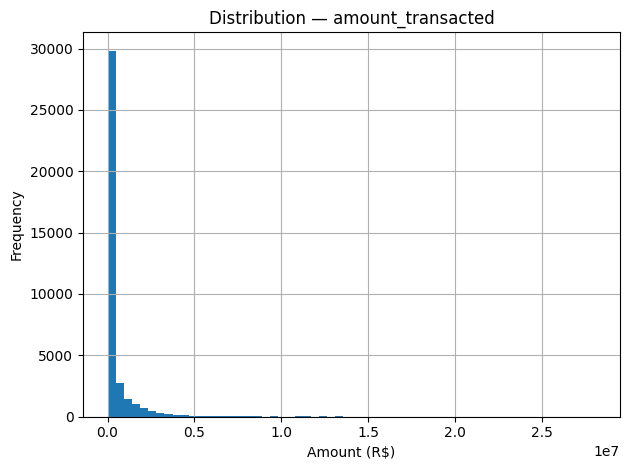

<Figure size 640x480 with 0 Axes>

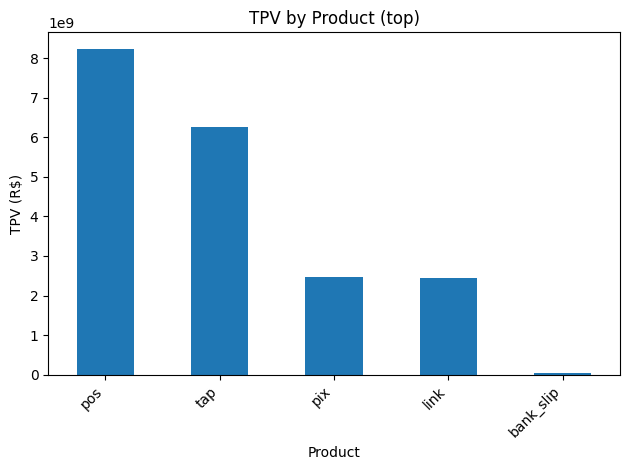

<Figure size 640x480 with 0 Axes>

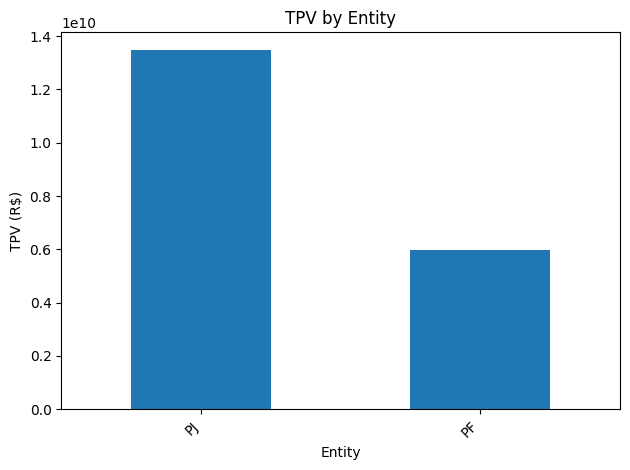

<Figure size 640x480 with 0 Axes>

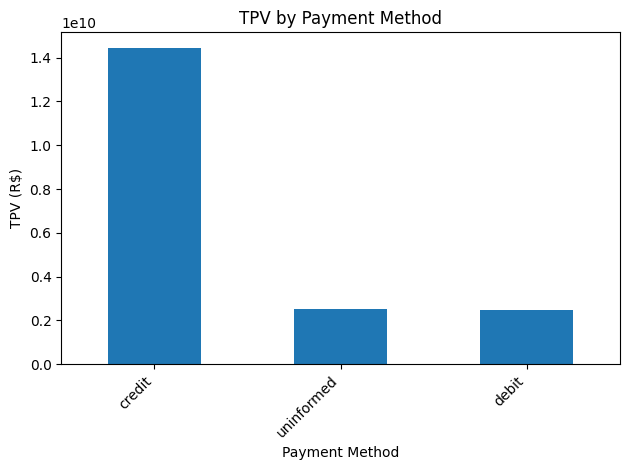

<Figure size 640x480 with 0 Axes>

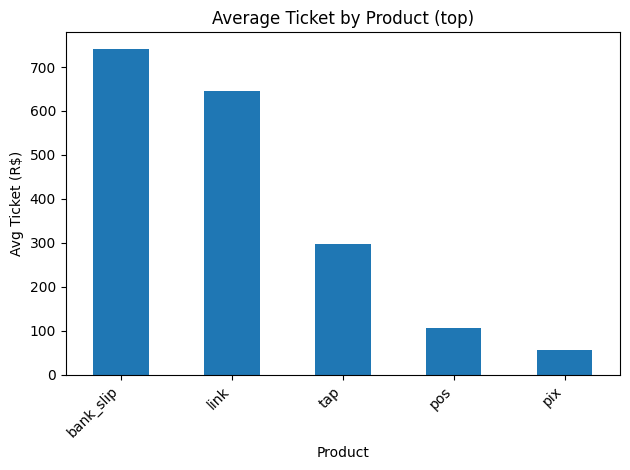

In [8]:
# Helper to keep figures clean
def bar(series_or_df, x=None, y=None, title="", xlabel="", ylabel=""):
    plt.figure()
    if x is None and y is None:
        series_or_df.plot(kind="bar")
    else:
        series_or_df.plot(kind="bar", x=x, y=y, legend=False)
    plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# 7.1 Distribution of amount_transacted
plt.figure()
df["amount_transacted"].hist(bins=60)
plt.title("Distribution — amount_transacted")
plt.xlabel("Amount (R$)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 7.2 TPV by product/entity/payment method
bar(tpv_by_product.sort_values("tpv", ascending=False).head(10),
    x="product", y="tpv", title="TPV by Product (top)",
    xlabel="Product", ylabel="TPV (R$)")

bar(tpv_by_entity.sort_values("tpv", ascending=False),
    x="entity", y="tpv", title="TPV by Entity",
    xlabel="Entity", ylabel="TPV (R$)")

bar(tpv_by_payment.sort_values("tpv", ascending=False),
    x="payment_method", y="tpv", title="TPV by Payment Method",
    xlabel="Payment Method", ylabel="TPV (R$)")

# 7.3 Avg Ticket by product
bar(avg_by_product.sort_values("avg_ticket", ascending=False).head(10),
    x="product", y="avg_ticket", title="Average Ticket by Product (top)",
    xlabel="Product", ylabel="Avg Ticket (R$)")

### Temporal & Behavioral Patterns

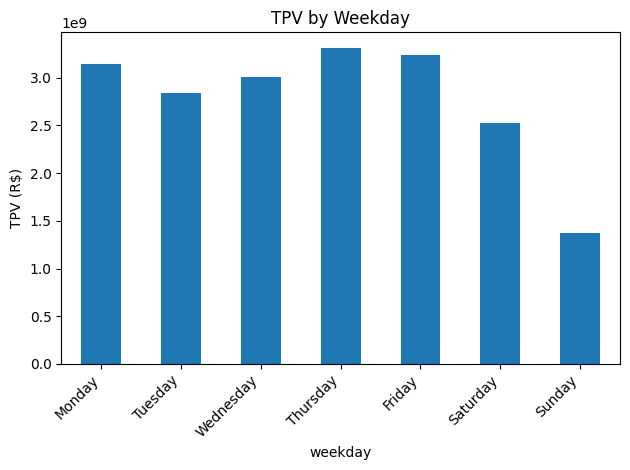

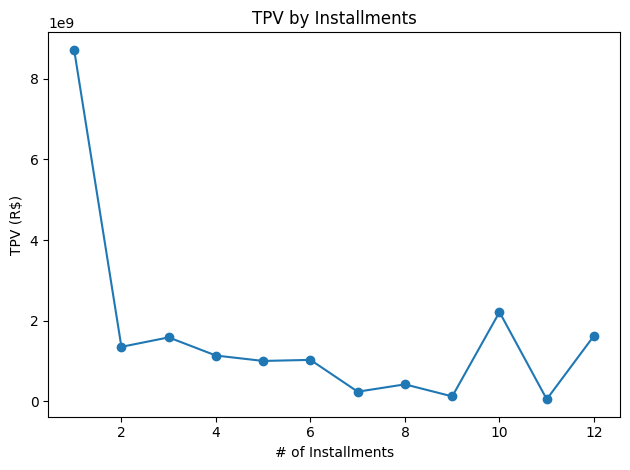

In [9]:
# Weekday effect (if day present)
if "weekday" in df.columns:
    wk = df.groupby("weekday")["amount_transacted"].sum().reindex(
        ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    )
    bar(wk, title="TPV by Weekday", ylabel="TPV (R$)")

# Installments effect (if column present)
if "installments" in df.columns:
    inst_tpv = df.groupby("installments")["amount_transacted"].sum().sort_index()
    plt.figure()
    inst_tpv.plot(kind="line", marker="o")
    plt.title("TPV by Installments")
    plt.xlabel("# of Installments")
    plt.ylabel("TPV (R$)")
    plt.tight_layout()
    plt.show()

### Findings

## 9. Findings (pre-dashboard)

- Data loaded successfully and passed basic ETL checks (dtypes, nulls, duplicates).
- Core KPIs computed: **TPV**, **Total Transactions**, **Average Ticket**, **Total Merchants**.
- Early patterns observed:
  - **POS/TAP** lead TPV; **Credit** dominates payment methods.
  - **PF** tends to have a **higher average ticket** than **PJ**.
  - TPV is concentrated in **1x–2x installments**; longer plans are marginal.
  - Weekday pattern suggests **mid-week strength** (if applicable to the dataset range).

These results informed the Looker Studio dashboard structure and the AI bot proposal (daily KPIs + anomaly alerts).